# Exploring a Direct-Marketing Dataset - Feature Selection
### (Uses code snippets and ideas from Kevin L. Davenport, Sebastian Raschka, and Jason Brownlee)

## Looking at the Dataset as a Whole

In the notebook titled "Exploratory-Data-Analysis" we looked at some methods for making sense of the dataset. We could try out various simple hypotheses and literally see if the data would bear them out. To make this exploration more precises we'll have to answer the usual pesky questions of estimates and error and p-value and confidence level, and so on. 

And of course, when the number of features are in the 1000s or even in the millions -- quite typical for datasets used in machine learning -- it becomes untenable to do the kind of exploratory data analysis we did above.

Can we do better? Can we get away from the assumptions we need to get these types of estimates? Can we wrap our heads around the the *complete* dataset?

So we'll have to use different techniques to make sense of whether and how the features are together related to each other.

We can, but first we need to clean up the data and convert the categorical variables to numeric scales.

In [1]:
# Import packages
import os
import time
import csv
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import wraps
from matplotlib.font_manager import FontProperties
from scipy import interp
from tabulate import tabulate

/Users/jsubapple/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Import SciKit Learn packages
from sklearn import model_selection #where the cross_validation and learning_curve modules live
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [3]:
%matplotlib inline

In [4]:
%%html
<!-- make markdown table pretty -->
<style>table {float:left}</style>

## Get the Already Pre-Processed Data

In [5]:
# Get the dataframe that was pickled in the Exploratory-Data-Analysis notebook
data = pd.read_pickle(os.getcwd() + '/Data/bank-additional/bank-additional-full_pickled')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We know some things about this data already. From the brief analysis in the Exploratory-Data-Analysis notebook we could already make some reasoned decisions about dropping certain features from the dataset. In this notebook we'll go further by looking at a number of feature selection techniques.

## One-Hot Encoding

So now let's handle the categorical attributes which all happen to be nominal variables -- i.e., they have no natural ordering or ranking.
- job
- marital
- education
- default
- housing
- loan
- contact
- month
- day_of_week
- poutcome

When attributes are ordinal, we can use mapping or label encoding to turn the text attribute values into numerical attribute values. But when the attributes are nominal, it's best to use *one-hot encoding*.

In [6]:
# list(data) returns the column names as a list
# Pandas get_dummies automatically converts every categorical variable to an equivalent one-hot encoding
# We can do this for our dataset without hesitation because all our categorical variables are nominal 
# -- i.e., they don't have any rank ordering.
# Note: this changes the ordering of the attributes in the dataframe
data2 = pd.get_dummies(data[list(data)])
data2.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [7]:
#Looks great except that we've one-hot encoded our outcome as well -- the dependent variable.
#Let's fix that.
data2['y'] = data2['y_yes'].map(lambda x: 1 if x > 0 else 0)
del data2['y_no']
del data2['y_yes']
data2.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0


## An Alternative Way to Convert the Outcome Variable into Numerical Values

In [8]:
# The last column contains info on whether the person bought the product or not
# The outcomes in the raw data are labeled 'yes' and 'no'.
# Change them into numerical outcomes -- 0 for no and 1 for yes
y = pd.Series([0 if val == 'no' else 1 for val in data.iloc[:,-1]])
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

Let's use data2 as our dataset from now on.

## Get the Inputs and the Output

We need the data in the form of arrays so we can compute using the inputs.

In [9]:
# Get the input matrix and the output vector
n_features = data2.shape[1]
X, y = data2.iloc[:,0:n_features-1].values, data2.iloc[:, n_features-1].values

## Rescale the Features

Since our features are on scales that differ by orders of magnitude, it's essential to rescale them. This makes it possible to compute efficiently on the dataset.

In [10]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)

## Feature Selection Techniques

### Remove Repetitive Features - Ones that Don't Vary a Lot in the Dataset

As explained in the SciKit Learn documentation, "VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples."

Let's apply it to our dataset to see which features this might hold true of (if any).

In [11]:
# Remove any feature that is the same value in threshold% or more of the dataset
# Scaling actually gets in the way of this -- so that's why we've used
# std_scaler.inverse_transform below.
from sklearn.feature_selection import VarianceThreshold
threshold = 0.7 # Set to be any real between and including 0 and 1
# The higher the threshold value, the fewer the number of removed features
# Conversely, the lower the threshold value, the higher the number of removed features
selector = VarianceThreshold(threshold=(threshold * (1 - threshold)))
selector.fit_transform(std_scaler.inverse_transform(X))

array([[  56.,  261.,    1., ...,    0.,    1.,    1.],
       [  57.,  149.,    1., ...,    0.,    1.,    1.],
       [  37.,  226.,    1., ...,    0.,    1.,    1.],
       ..., 
       [  56.,  189.,    2., ...,    1.,    0.,    0.],
       [  44.,  442.,    1., ...,    1.,    0.,    0.],
       [  74.,  239.,    3., ...,    1.,    0.,    0.]])

In [12]:
# Index values of the features that *do* vary and hence are useful to keep around
idx_features_selected = selector.get_support(indices=True)
print idx_features_selected

[ 0  1  2  3  4  5  6  7  8  9 23 37 39 43 44 51]


In [13]:
# Get all the column names in our dataset *except* for the outcome variable name
col_names = list(data2.columns.values)[0:-1]

In [14]:
# Selected features by name
names_features_selected = [col_names[i] for i in idx_features_selected]
names_features_selected

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'marital_married',
 'housing_no',
 'housing_yes',
 'contact_cellular',
 'contact_telephone',
 'month_may']

In [15]:
# Features not selected because they are the same value for more than 80% of the dataset
names_features_not_selected = list(set(col_names) - set(names_features_selected))
names_features_not_selected

['job_admin.',
 'education_professional.course',
 'job_management',
 'marital_unknown',
 'marital_single',
 'job_student',
 'job_services',
 'education_university.degree',
 'education_basic.9y',
 'education_high.school',
 'marital_divorced',
 'job_unemployed',
 'month_sep',
 'education_basic.4y',
 'poutcome_failure',
 'poutcome_nonexistent',
 'default_no',
 'job_housemaid',
 'loan_unknown',
 'day_of_week_thu',
 'job_entrepreneur',
 'day_of_week_tue',
 'month_mar',
 'poutcome_success',
 'loan_yes',
 'job_unknown',
 'month_nov',
 'month_oct',
 'housing_unknown',
 'job_retired',
 'job_blue-collar',
 'job_self-employed',
 'education_basic.6y',
 'month_jul',
 'day_of_week_fri',
 'month_aug',
 'education_unknown',
 'month_dec',
 'day_of_week_wed',
 'default_yes',
 'education_illiterate',
 'default_unknown',
 'job_technician',
 'day_of_week_mon',
 'month_apr',
 'loan_no',
 'month_jun']

At the threshold value we set, we could do away with these features to make our dataset more manageable.

### L1 Regularization to Create Sparse Arrays

Regularization is a technique for reducing the influence of each feature on determining the output. The technique of L1 regularization doubles as a feature selection technique because it results in many of the features having zero-valued coefficients. For more information about L1 regularization, have a look at Sebastian Raschka's *Python Machine Learning* pp.112-115.

In [16]:
# Split the data into test and training data sets
# NOTE: The features have already been scaled in X
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
# Fit a logistic regression model to X_train using an L1 "penalty"
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train, y_train)
accuracy_train = lr.score(X_train, y_train)
accuracy_train

0.91079046859283408

In [18]:
accuracy_test = lr.score(X_test, y_test)
accuracy_test

0.91187181354697744

In [19]:
y_predict = lr.predict(X_test)
confusion_matrix(y_test, y_predict)

array([[10673,   296],
       [  793,   595]])

The training and test accuracy are both high and almost the same. This shows there's no overfitting. But we have to be cautious since we know the dataset is imbalanced -- there are few 1 outputs compared to the majority of 0 outputs.

This makes it imperative to check other more meaningful measures of performance like precision and recall.

In [20]:
precision_score(y_test, y_predict)

0.66778900112233441

In [21]:
recall_score(y_test, y_predict)

0.42867435158501443

So far so good. Which features have been eliminated by the L1 regularization?

In [22]:
# Optimally chosen parameter values -- the ones that best fit the model
# Zero values show that the corresponding feature has been eliminated
lr.coef_

array([[ 0.        ,  1.19516314, -0.10400952, -0.22485801, -0.02395745,
        -1.59423213,  0.73929774,  0.09815166,  0.08296431,  0.        ,
         0.        , -0.11447728,  0.00380634,  0.00608905,  0.03048433,
         0.05094982, -0.01270852, -0.03190055,  0.03053418,  0.        ,
         0.0036735 , -0.01413308, -0.00849398,  0.        ,  0.01056485,
         0.        , -0.00415845,  0.00506361,  0.        , -0.01021721,
         0.01785895,  0.        ,  0.03893482,  0.01536698,  0.03283579,
        -0.05935818,  0.        ,  0.00162208, -0.00521297,  0.        ,
         0.02265049, -0.01266404,  0.        ,  0.19399067, -0.01337361,
         0.        ,  0.21597558,  0.01689613,  0.08608684, -0.02290826,
         0.19972118, -0.25666062, -0.07722336,  0.02408762,  0.01653496,
        -0.07591445, -0.07459762,  0.        ,  0.01072712,  0.        ,
        -0.13310167,  0.        ,  0.05079371]])

In [40]:
# Which features are eliminated? 
idx_selected = np.where(lr.coef_ != 0)[1]
idx_not_selected = np.where(lr.coef_ == 0)[1]
idx_selected, idx_not_selected

(array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 20,
        21, 22, 24, 26, 27, 29, 30, 32, 33, 34, 35, 37, 38, 40, 41, 43, 44,
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 60, 62]),
 array([ 0,  9, 10, 19, 23, 25, 28, 31, 36, 39, 42, 45, 57, 59, 61]))

In [42]:
feat_selected = [col_names[i] for i in idx_selected]
feat_not_selected = [col_names[i] for i in idx_not_selected]
feat_selected, feat_not_selected

(['duration',
  'campaign',
  'pdays',
  'previous',
  'emp_var_rate',
  'cons_price_idx',
  'cons_conf_idx',
  'euribor3m',
  'job_blue-collar',
  'job_entrepreneur',
  'job_housemaid',
  'job_management',
  'job_retired',
  'job_self-employed',
  'job_services',
  'job_student',
  'job_unemployed',
  'job_unknown',
  'marital_divorced',
  'marital_single',
  'education_basic.4y',
  'education_basic.6y',
  'education_high.school',
  'education_illiterate',
  'education_university.degree',
  'education_unknown',
  'default_no',
  'default_unknown',
  'housing_no',
  'housing_unknown',
  'loan_no',
  'loan_unknown',
  'contact_cellular',
  'contact_telephone',
  'month_aug',
  'month_dec',
  'month_jul',
  'month_jun',
  'month_mar',
  'month_may',
  'month_nov',
  'month_oct',
  'month_sep',
  'day_of_week_fri',
  'day_of_week_mon',
  'day_of_week_tue',
  'poutcome_failure',
  'poutcome_success'],
 ['age',
  'nr_employed',
  'job_admin.',
  'job_technician',
  'marital_married',
  'mar

So a whole bunch of columns can be eliminated including some surprising ones like age, whether the person has defaulted on a previous loan, etc. And by the way, calling on a Wednesday or Thursday seems pointless!

### Recursive Feature Elimination

As Jason Brownlee explains, "Recursive Feature Elimination (RFE) works by recursively removing attributes and building a model on those attributes that remain." (machinelearningmastery.com/feature-selection-machine-learning-python/)

When we use RFE we specify the number of features we'd like to keep. So how about keeping the top 10 features?

In [73]:
# Feature extraction using RFE
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, 10)
fit = rfe.fit(X_train, y_train)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: 10
Selected Features: [False  True False  True False  True  True False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False  True False
 False False  True  True False False False False False False False False
 False False False]
Feature Ranking: [37  1  7  1 18  1  1  9  1  1 26  5 27 28 19 15 44 43 17 25 29 40 39 41 52
 53 47 38 48 46 33 50 14 36  8 16 30 51 32 54 20 42 45  6  1 49  1 35 21  4
  1  1  2 34 31 10 11 23 22 24  3 13 12]


The features ranked with a 1 are the top features selected. Let's find out which features these are.

In [71]:
type(fit.ranking_)

numpy.ndarray

In [96]:
feat_top = [col_names[i] for i in np.where(fit.ranking_ == 1)[0].tolist()]
# idx_list = idx[0].tolist()
#idx_list
feat_top

['duration',
 'pdays',
 'emp_var_rate',
 'cons_price_idx',
 'euribor3m',
 'nr_employed',
 'contact_telephone',
 'month_aug',
 'month_mar',
 'month_may']

That's interesting! The longer the call duration the higher the chance of a sale. Economic conditions play a big role. So does being contacted at a land line rather than a cell phone. And finally, the months of March, May, and August seem to be the months to call. 

### Ranking Feature Importance Using Random Forests

Here we just have the code -- please see Sebastian Raschka's *Python Machine Learning* (pp. 80-92 and 124-126) for an explanation of decision trees and the random forests built from them.

In [76]:
# Code is from Raschka (pp.125-125)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [77]:
importances = forest.feature_importances_

array([  7.86146937e-02,   2.70474714e-01,   3.90992517e-02,
         3.13411374e-02,   1.24147363e-02,   2.35617549e-02,
         2.36828599e-02,   2.61918667e-02,   9.25210945e-02,
         4.91574655e-02,   1.21887400e-02,   8.21632433e-03,
         3.69245770e-03,   3.03200187e-03,   6.63801018e-03,
         5.63361070e-03,   3.80109368e-03,   6.31632995e-03,
         4.19179420e-03,   9.92517765e-03,   3.77256270e-03,
         1.58373711e-03,   7.17002729e-03,   1.20243596e-02,
         1.10413246e-02,   4.46991366e-04,   6.36692971e-03,
         4.15852264e-03,   7.76475354e-03,   1.12493763e-02,
         1.82918741e-04,   8.29294810e-03,   1.22543508e-02,
         4.81295272e-03,   5.59452789e-03,   5.53253969e-03,
         3.36901854e-08,   1.34927205e-02,   1.77586440e-03,
         1.34623793e-02,   9.33096001e-03,   1.75717949e-03,
         9.11159335e-03,   6.61126041e-03,   6.63941021e-03,
         3.46674232e-03,   2.71238710e-03,   9.35441034e-04,
         2.79504390e-03,

([<matplotlib.axis.XTick at 0x26dca5ad0>,
 <a list of 63 Text xticklabel objects>)

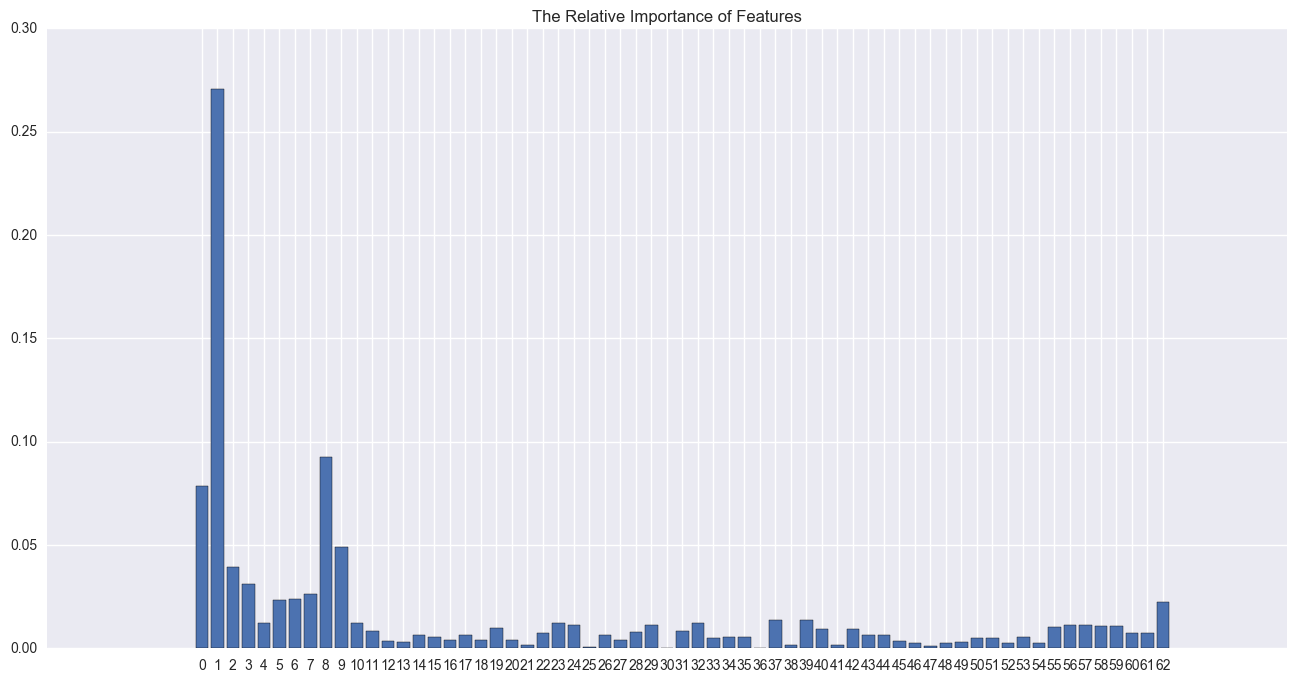

In [94]:
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(range(X_train.shape[1]), importances, align='center')
plt.title('The Relative Importance of Features')
plt.xticks(range(X_train.shape[1]))
#plt.figure(figsize=(16,8))

Let's see which features have an outsized impact:

In [95]:
[col_names[i] for i in [0,1,8,9]]

['age', 'duration', 'euribor3m', 'nr_employed']

We find that different features are highlighted or discarded by the feature selection techniques. That's what makes feature selection and model building an art as well as a science.

Check out the following links for more ideas on feature selection. 
- http://machinelearningmastery.com/feature-selection-machine-learning-python/ (Jason Brownlee)
- http://scikit-learn.org/stable/modules/feature_selection.html (SciKit Learn documentation)
- http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline (SciKit Learn documentation)